<a href="https://colab.research.google.com/github/erzar0/engineering-thesis/blob/main/proof_of_concept.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Tue Dec 26 20:14:55 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P8              12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import random
from collections import defaultdict

num2elem = defaultdict(str)
# num2elem.update({
#     0 : "ca"
#     , 1 : "cu"
#     , 2 : "zn"
#     , 3 : "fe"
#     , 4 : "pb"
# })

# element_lines = {
#     0 : (("k_alpha", 3.69, 0.5), ("k_beta", 4.01, 0.5),)
#     , 1 : (("k_alpha", 8.04, 1), ("k_beta", 8.91, 0.4))
#     , 2 : (("k_alpha", 8.64, 1), ("k_beta", 9.57, 0.2))
#     , 3 : (("k_alpha", 6.4, 1), ("k_beta", 7.06, 0.1))
#     , 4 : (("l_alpha", 10.5, 1), ("l_beta", 12.6, 0.9), ("m_alpha", 2.82, 0.01), ("m_beta", 3.16, 0.01))
# }

num2elem.update({
    0: "K"
    , 1:"Ca"
    , 2: "Ti"
    , 3: "V"
    , 4: "Cr"
    , 5: "Mn"
    , 6: "Fe"
    , 7: "Co"
    , 8: "Ni"
    , 9: "Cu"
    , 10: "Zn"
    , 11: "As"
    , 12: "Se"
    , 13: "Cd"
    , 14: "Sn"
    , 15: "Sb"
    , 16: "Au"
    , 17: "Hg"
    , 18: "Pb"
    , 19: "Bi"
})

element_lines = {
    0: (("k_alpha", 3.314, 1), )
    , 1: (("k_alpha", 3.692, 1), )
    , 2: (("k_alpha", 4.512, 1), )
    , 3: (("k_alpha", 4.953, 1), ("k_alpha_esc", 1.995, 0.2))
    , 4: (("k_alpha", 5.415, 1), ("k_alpha_esc", 2.457, 0.2))
    , 5: (("k_alpha", 5.900, 1), ("k_alpha_esc", 2.942, 0.2))
    , 6: (("k_alpha", 6.405, 1), ("k_alpha_esc", 3.447, 0.2))
    , 7: (("k_alpha", 6.931, 1), ("k_alpha_esc", 3.973, 0.2))
    , 8: (("k_alpha", 7.480, 1), ("k_alpha_esc", 4.522, 0.2))
    , 9: (("k_alpha", 8.046, 1), ("k_alpha_esc", 5.088, 0.2))
    , 10: (("k_alpha", 8.637, 1), ("k_alpha_esc", 5.679, 0.2))
    , 11: (("k_alpha", 10.543, 1), ("k_alpha_esc", 7.585, 0.2))
    , 12: (("k_alpha", 11.224, 1), ("k_alpha_esc", 8.266, 0.2))
    , 13: (("l_alpha", 3.133, 1), )
    , 14: (("l_alpha", 3.444, 1), )
    , 15: (("l_alpha", 3.604, 1), )
    , 16: (("l_alpha", 9.713, 1), ("l_beta", 11.443, 0.5))
    , 17: (("l_alpha", 9.989, 1), ("l_beta", 11.824, 0.5))
    , 18: (("l_alpha", 10.551, 1), ("l_beta", 12.614, 0.5))
    , 19: (("l_alpha", 10.839, 1), ("l_beta", 13.023, 0.5))
}


TARGET_VECTOR_LENGTH = len(element_lines.keys())
MIN_ENERGY = 0
MAX_ENERGY = 30
CHANNELS_COUNT = 4096

DETECTOR_BASE_SIGMA = 0.5
DETECTOR_SIGMA_COEF = 0.005
FANO = 5.8767709641972905

def gaussian(x, mu, sigma):
    return  np.exp(-(x - mu)**2 / (2 * sigma**2)) / (sigma * np.sqrt(2 * np.pi))

def get_random_percentages(n):
    random_percentages = np.random.uniform(0, 1, n)
    random_percentages /= np.sum(random_percentages)
    return random_percentages

def calculate_sigma(energy, use_fano=False):
    if use_fano:
        return np.sqrt((0.08/2.354)**2 + 0.00385 * FANO * energy)
    return DETECTOR_BASE_SIGMA - energy * DETECTOR_SIGMA_COEF

def generate_training_data(element_lines, mu_max_err = 0.000, sigma_max_err = 0.00, mu_max_err_global = 0.00, samples = 10, elements_per_sample = 3, element_numbers = None, use_percentages=False):
    X = [np.zeros(CHANNELS_COUNT) for i in range(samples)]
    y = [np.zeros(TARGET_VECTOR_LENGTH) for i in range(samples)]
    linspace = np.linspace(MIN_ENERGY, MAX_ENERGY, CHANNELS_COUNT)

    for i in range(samples):
        if element_numbers is None:
            selected_element_numbers = random.sample(sorted(element_lines), elements_per_sample)
        else:
            selected_element_numbers = element_numbers
        element_percentages = get_random_percentages(len(selected_element_numbers))
        mu_err_global = np.random.uniform(-mu_max_err_global, mu_max_err_global)

        for element_percentage, element_number in zip(element_percentages, selected_element_numbers):
            if use_percentages:
                y[i][element_number] = element_percentage
            else:
                y[i][element_number] = 1
            X_element = np.zeros(CHANNELS_COUNT)
            intensity_norm_coeff = 0

            for element_line in element_lines[element_number]:
                mu = element_line[1] + np.random.uniform(-mu_max_err, mu_max_err) + mu_err_global
                sigma = calculate_sigma(mu, use_fano=True) + np.random.uniform(-sigma_max_err, sigma_max_err)
                gauss = gaussian(linspace, mu, sigma)

                intensity = element_line[2]
                intensity_norm_coeff += intensity
                line_gauss = gauss * intensity

                # plt.figure(random.randint(1, 1e10), figsize=(4,3))
                # plt.title(f"Line {element_line[0]} of {num2elem[element_number]}")
                # plt.plot(linspace, line_gauss)
                # plt.savefig(f"Line {element_line[0]} of {num2elem[element_number]}.svg")

                X_element += line_gauss


            X_element /= intensity_norm_coeff
            X_element *= element_percentage
            X[i] += X_element

            # plt.figure(random.randint(1, 1e10), figsize=(4,3))
            # plt.title(f"{element_percentage * 100:.2f}% of {num2elem[element_number]} spectrum")
            # plt.plot(linspace, X_element)
            # plt.savefig(f"{num2elem[element_number]} spectrum.svg")

        X[i] /= np.max(X[i])

        # plt.figure(random.randint(1, 1e10), figsize=(4,3))
        # plt.title("Normalized sum of spectra")
        # plt.plot(linspace, X[i])
        # plt.savefig("Normalized sum of spectra.svg")

        X[i] += np.exp(-np.linspace(np.random.uniform(1.5, 3), np.random.uniform(4, 6), CHANNELS_COUNT))
        X[i] /= np.max(X[i])

        # plt.figure(random.randint(1, 1e10), figsize=(4,3))
        # plt.title("Exponential function added")
        # plt.plot(linspace, X[i])
        # plt.savefig("Exponential function added.svg")

    return X, y

def get_percentages_y(target, do_print=True):
    percentages = defaultdict(float)
    for i in range(TARGET_VECTOR_LENGTH):
        percentages[i] = target[i]
    percentages = sorted(percentages.items(), key=lambda item: item[1], reverse=True)
    percentages = [(num2elem[k], v) if k in num2elem else ('', v) for k, v in percentages]
    if(do_print):
        print(percentages)
    return percentages

example_X, example_y = generate_training_data(element_lines, mu_max_err = 0.002, sigma_max_err = 0.05, mu_max_err_global = 0.05, samples=1,  elements_per_sample=3, element_numbers = [9, 18], use_percentages=True)
# example_X, example_y = generate_training_data(element_lines, mu_max_err = 0.002, sigma_max_err = 0.05, mu_max_err_global = 0.05, samples=100,  elements_per_sample=10, element_numbers = [9, 18], use_percentages=True)
# example_X = np.asarray(example_X)
# example_y = np.asarray(example_y)


# get_percentages_y(example_y[0])
# labels = [", ".join([f'({el[0]} - {el[1]:.2f})' for el in get_percentages_y(example_y[i], do_print=False) if el[1] > 0]) for i in range(4)]
# print(labels)

# [plt.plot(np.linspace(MIN_ENERGY, MAX_ENERGY, CHANNELS_COUNT), example_X[i*2 + j]
#           , label=f"{labels[i*2 + j]}") for i in range(2) for j in range(2)]
# plt.title("Composed spectras with different amounts of Cu and Pb")
# plt.xlabel("Energy [KeV]")
# plt.ylabel("Normalized intensity [-]")
# plt.legend()
# plt.savefig("sum-spectras.svg")

# fig, axs = plt.subplots(2, 2, figsize=(12, 12))
# [axs[i][j].plot(np.linspace(MIN_ENERGY, MAX_ENERGY, CHANNELS_COUNT), example_X[i*2 + j]
#           , label=f"{labels[i*2 + j]}") for i in range(2) for j in range(2)]
# fig.legend()

# [axs[i][j].plot(np.linspace(MIN_ENERGY, MAX_ENERGY, CHANNELS_COUNT), example_X[i*2 + j]) for i in range(2) for j in range(4)]


In [ ]:
!pip install graphviz
!apt-get install graphviz
!pip install torchview

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


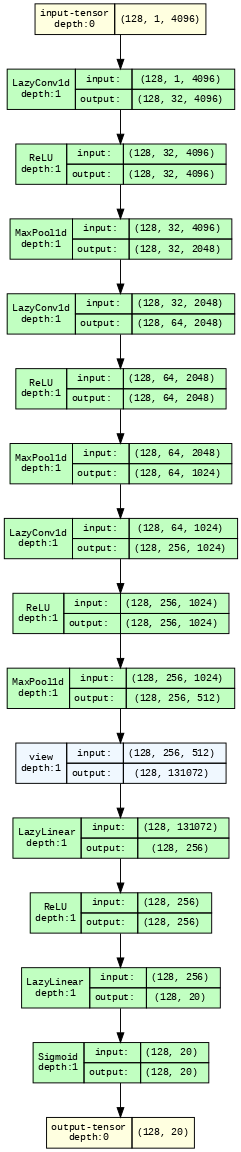

In [ ]:
import graphviz
import pandas as pd
import random
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
from graphviz import Source
from torch.utils.data import DataLoader
from torchview import draw_graph
from torchvision import transforms, datasets

class VisionTransformer(nn.Module):
    def __init__(self, input_size, patch_size, embed_dim, num_heads, num_classes, num_layers, hidden_dim, dropout_rate):
        super(VisionTransformer, self).__init__()
        num_patches = input_size // patch_size
        self.patch_embed = nn.Conv1d(1, embed_dim, kernel_size=patch_size, stride=patch_size, bias=False)
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches, embed_dim))
        self.dropout = nn.Dropout(dropout_rate)
        self.transformer_blocks = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads, hidden_dim, dropout_rate) for _ in range(num_layers)
        ])
        self.norm = nn.LayerNorm(embed_dim)
        self.fc = nn.Linear(embed_dim * num_patches, num_classes)
        self.gelu = nn.GELU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.patch_embed(x)
        x = x.flatten(2).transpose(1, 2)
        x = self.dropout(x + self.pos_embed)
        for i, block in enumerate(self.transformer_blocks):
            x = block(x)
        x = self.norm(x)
        x = x.reshape(x.size(0), -1)

        x = self.fc(x)
        x = self.sigmoid(x)
        return x

class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, hidden_dim, dropout_rate):
        super(TransformerBlock, self).__init__()

        self.norm1 = nn.LayerNorm(embed_dim)
        self.attention = nn.MultiheadAttention(embed_dim, num_heads)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.feedforward = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, embed_dim),
            nn.Dropout(dropout_rate)
        )

    def forward(self, x):
        global attention_weights
        attn_output, attn_weights = self.attention(*([self.norm1(x)] * 3), need_weights=True)
        attention_weights = attn_weights
        x = x + attn_output
        x = x + self.feedforward(self.norm2(x))

        return x

class CNN1DClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(CNN1DClassifier, self).__init__()
        self.conv1 = nn.LazyConv1d(32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.LazyConv1d(64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.LazyConv1d(128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.LazyConv1d(256, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.fc1 = nn.LazyLinear(256)
        self.fc2 = nn.LazyLinear(num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)  # Flatten the input for the fully connected layer
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x




input_size = 4096
patch_size = 16
embed_dim = 16
num_heads = 4
num_classes = 20
num_layers = 6
hidden_dim = 4 * embed_dim
dropout_rate = 0.1

# model = VisionTransformer(input_size, patch_size, embed_dim, num_heads, num_classes, num_layers, hidden_dim, dropout_rate)
model = CNN1DClassifier(4096, 20)

graph = draw_graph(model, input_size=(128, 1, 4096), expand_nested=True, depth=1)
graphviz.set_jupyter_format('png')
graph.visual_graph


In [ ]:
model.load_state_dict(torch.load("vit_equal_classes.pt", map_location=torch.device('cuda')))

FileNotFoundError: ignored

In [ ]:
!nvidia-smi
pytorch_total_params = sum(p.numel() for p in model.parameters())
print(pytorch_total_params)


Mon Jan  1 16:12:38 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0              49W / 400W |   2883MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [ ]:
artificial_data = [generate_training_data(element_lines, mu_max_err = 0.002, sigma_max_err = 0.05, mu_max_err_global=0.05, samples = 10000 ,  elements_per_sample = i, element_numbers = None) for i in range(1, 10)]

In [ ]:
import copy
from functools import reduce
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

def create_dataloader(X, y, device, batch_size=16, shuffle=True):
    X_train_tensor = torch.tensor(X, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y, dtype=torch.float32).to(device)
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    return DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

def train(model, train_loader, valid_loader, optimizer, criterion, epochs = 3):
    best_loss = np.inf
    best_weights = None
    train_history = []
    valid_history = []
    for epoch in range(epochs):
        model.train()
        print(f"Epoch {epoch}")
        train_loss = 0
        idx = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            torch.cuda.empty_cache()

            idx += 1
            train_loss += float(loss)
            if idx % 10 == 0:
                print(f"Batch {idx}, loss: {float(loss)}")

        train_loss = train_loss/idx
        print("train epoch avg loss: %.2f" % train_loss)
        train_history.append(train_loss)

        with torch.no_grad():
            model.eval()
            def _calc_loss(dataloader):
                loss_acc = 0
                for X_batch, y_batch in dataloader:

                    y_pred = model(X_batch)
                    loss = criterion(y_pred, y_batch)
                    loss_acc += float(loss)
                return loss_acc / len(dataloader)

            valid_loss = _calc_loss(valid_loader)
            print("valid loss: %.2f" % valid_loss)
            valid_history.append(valid_loss)
            if valid_loss < best_loss:
                best_loss = valid_loss
                best_weights = copy.deepcopy(model.state_dict())

    return train_history, valid_history, best_loss, best_weights


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(DEVICE)

BATCH_SIZE = 256
EPOCHS = 10

X, y = reduce(lambda acc, val: (acc[0] + val[0], acc[1] + val[1]) , artificial_data, ([], []))
X = np.asarray(X).reshape(-1, 1, CHANNELS_COUNT)
y = np.asarray(y)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.9, shuffle=True)
train_loader = create_dataloader(X_train, y_train, DEVICE, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = create_dataloader(X_valid, y_valid, DEVICE, batch_size=BATCH_SIZE, shuffle=True)

optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.BCELoss()

train_history, valid_history, best_loss, best_weights = train(model, train_loader, valid_loader, optimizer, criterion, epochs = EPOCHS)
model.load_state_dict(best_weights)

Epoch 0
Batch 10, loss: 0.582806408405304
Batch 20, loss: 0.5513127446174622
Batch 30, loss: 0.5308429002761841
Batch 40, loss: 0.5061179995536804
Batch 50, loss: 0.48221513628959656
Batch 60, loss: 0.45899802446365356
Batch 70, loss: 0.40000882744789124
Batch 80, loss: 0.3940768539905548
Batch 90, loss: 0.34535273909568787
Batch 100, loss: 0.32657209038734436
Batch 110, loss: 0.3317631185054779
Batch 120, loss: 0.30066511034965515
Batch 130, loss: 0.28905948996543884
Batch 140, loss: 0.276854008436203
Batch 150, loss: 0.2794470489025116
Batch 160, loss: 0.2571053206920624
Batch 170, loss: 0.26514145731925964
Batch 180, loss: 0.2571447491645813
Batch 190, loss: 0.2478356659412384
Batch 200, loss: 0.24976305663585663
Batch 210, loss: 0.23905697464942932
Batch 220, loss: 0.23610234260559082
Batch 230, loss: 0.2375137358903885
Batch 240, loss: 0.22994934022426605
Batch 250, loss: 0.22996321320533752
Batch 260, loss: 0.24364633858203888
Batch 270, loss: 0.20594559609889984
Batch 280, loss:

<All keys matched successfully>

loss: 0.15


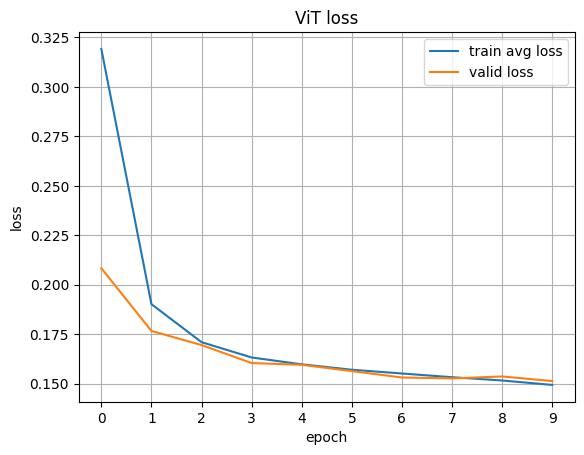

In [ ]:
torch.save(model.state_dict(), "./vit_equal_classes")

print("loss: %.2f" % best_loss)

plt.grid(True)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.xticks(range(len(train_history)))
plt.title("ViT loss")
plt.plot(train_history, label="train avg loss")
plt.plot(valid_history, label="valid loss")
plt.legend()
plt.savefig("vit_equal_classes_loss.svg")

100%|██████████| 20/20 [00:02<00:00,  8.81it/s]


Avg auc: 0.9662809557346346


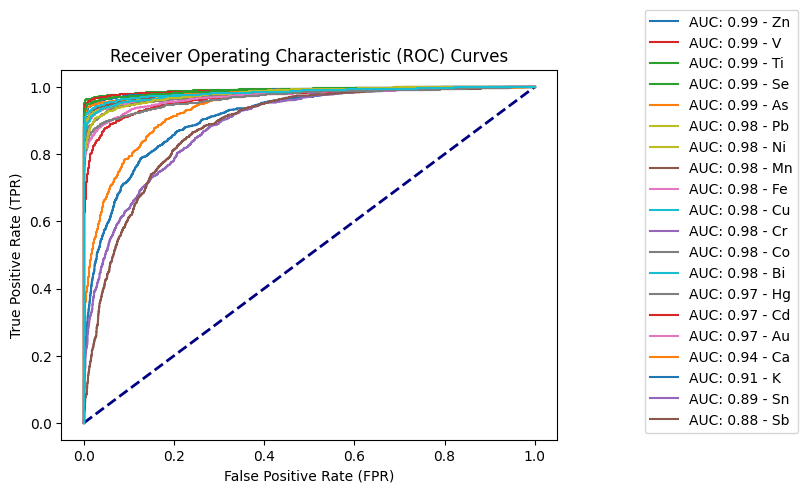

In [ ]:
from sklearn.metrics import roc_curve, auc
from functools import reduce
from tqdm import tqdm


def get_test_loader(samples, elements_per_sample_range=(1, 2)):
    samples = samples // (elements_per_sample_range[1] - elements_per_sample_range[0])
    artificial_data = [generate_training_data(element_lines, mu_max_err = 0.002, sigma_max_err = 0.05, mu_max_err_global=0.05, samples = samples,  elements_per_sample = i, element_numbers = None) for i in range(*elements_per_sample_range)]
    X, y = reduce(lambda acc, val: (acc[0] + val[0], acc[1] + val[1]) , artificial_data, ([], []))
    X = np.asarray(X).reshape(-1, 1, CHANNELS_COUNT)
    y = np.asarray(y)

    test_loader = create_dataloader(X, y, DEVICE, batch_size=BATCH_SIZE, shuffle=True)
    return test_loader


def calculate_roc(test_loader):

    pred_labels = [[] for i in range(TARGET_VECTOR_LENGTH)]
    real_labels = [[] for i in range(TARGET_VECTOR_LENGTH)]
    with torch.no_grad():
        model.eval()
        for X_batch, y_batch in test_loader:
            for y in y_batch:
                for i, label in enumerate(y):
                    real_labels[i].append(label.to("cpu"))

            y_pred = model(X_batch)
            for y in y_pred:
                for i, label in enumerate(y):
                    pred_labels[i].append(label.to("cpu"))

    aucs = []
    handles_list = []
    labels_list = []
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guessing')
    for i in tqdm(range(TARGET_VECTOR_LENGTH)):
        fpr, tpr, thresholds = roc_curve(real_labels[i], pred_labels[i])
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)

        line, = plt.plot(fpr, tpr)

        handles_list.append(line)
        labels_list.append(f"AUC: {roc_auc:.2f} - {num2elem[i].capitalize()}")

    sorted_lists = sorted(zip(labels_list, handles_list), key = lambda x: x[0], reverse=True)
    sorted_lists = list(zip(*sorted_lists))
    plt.legend(handles=sorted_lists[1], labels=sorted_lists[0], loc='lower right', bbox_to_anchor=(1.5, 0))
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Receiver Operating Characteristic (ROC) Curves')
    plt.savefig("vit_equal_classes_roc.svg")

    print(f"Avg auc: {sum(aucs)/len(aucs)}")

def calculate_accuracy_precision_recall_f1(test_loader):
    def _precision_recall_f1(y_true, y_pred, epsilon=1e-10):
        true_positives = torch.sum(y_true * y_pred, dim=0)
        false_positives = torch.sum((1 - y_true) * y_pred, dim=0)
        false_negatives = torch.sum(y_true * (1 - y_pred), dim=0)

        precision = true_positives / (true_positives + false_positives + epsilon)
        recall = true_positives / (true_positives + false_negatives + epsilon)

        f1 = 2 * (precision * recall) / (precision + recall + epsilon)

        precision = torch.mean(precision)
        recall = torch.mean(recall)
        f1 = torch.mean(f1)

        return precision.item(), recall.item(), f1.item()

    all_true_labels = []
    all_pred_labels = []
    all_accuracies = []
    with torch.no_grad():
        model.eval()

        for batch in test_loader:
            inputs, true_labels = batch
            outputs = model(inputs)

            pred_labels = (outputs > 0.5).float()

            accuracy = torch.mean((pred_labels == true_labels).float()).item()
            all_accuracies.append(accuracy)

            all_true_labels.append(true_labels)
            all_pred_labels.append(pred_labels)

        all_true_labels = torch.cat(all_true_labels, dim=0)
        all_pred_labels = torch.cat(all_pred_labels, dim=0)

    precision, recall, f1 = _precision_recall_f1(all_true_labels, all_pred_labels)
    accuracy = torch.mean(torch.tensor(all_accuracies)).item()

    return precision, recall, f1, accuracy

test_loaders = [get_test_loader(samples=1000, elements_per_sample_range=(i-1, i)) for i in range(2, 11)]
calculate_roc(get_test_loader(samples=5000, elements_per_sample_range=(1, 10)))
accuracy_precision_recall_f1s = [calculate_accuracy_precision_recall_f1(test_loader) for test_loader in test_loaders]


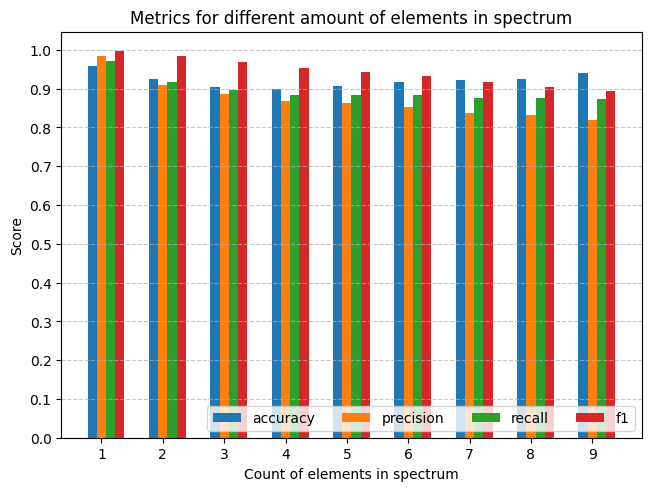

In [ ]:
accuracy, precisions, recals, f1s = list(zip(*accuracy_precision_recall_f1s))

element_counts  = list(range(1, 10))
fig, ax = plt.subplots(constrained_layout='constrained')
ax.grid(axis='y', linestyle='--', alpha=0.7)

stats_dict = {"accuracy": accuracy, "precision": precisions, "recall": recals, "f1": f1s}

width = 0.15  # the width of the bars
multiplier = 0
x = np.arange(len(element_counts))
for attribute, measurement in stats_dict.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    multiplier += 1

ax.set_ylabel('Score')
ax.set_xlabel('Count of elements in spectrum')
ax.set_title('Metrics for different amount of elements in spectrum')
ax.set_xticks(x + width, element_counts)
ax.set_yticks(np.linspace(0, 1, 11))
ax.legend(loc='lower right', ncols=4)
plt.savefig("vit_equal_classes_scores.svg")


1098
1107


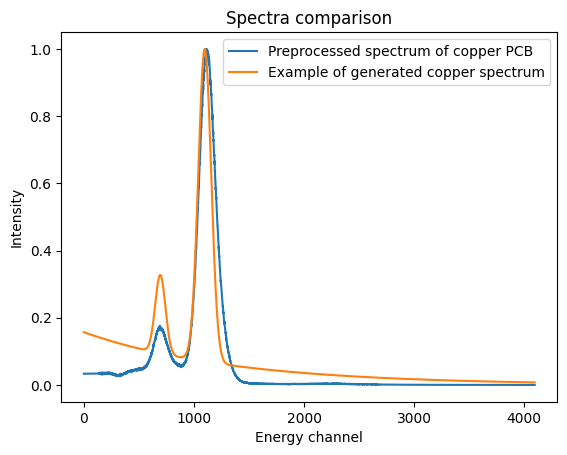

In [ ]:
import time
preprocessed_spectrum = np.load("copper_pcb_preprocessed_spectrum.npy")
example_X, example_y = generate_training_data(element_lines, mu_max_err = 0.002, sigma_max_err = 0.00, mu_max_err_global = 0.00, samples=100,  elements_per_sample=10, element_numbers = [9], use_percentages=True)
print(np.argmax(example_X[0]))
print(np.argmax(preprocessed_spectrum))

plt.xlabel("Energy channel")
plt.ylabel("Intensity")
plt.title("Spectra comparison")
plt.plot(preprocessed_spectrum, label="Preprocessed spectrum of copper PCB")
plt.plot(example_X[0], label="Example of generated copper spectrum")
plt.legend()
plt.savefig("spectra-comparison.svg")

[('Cu', 1.0), ('Pb', 0.008978110738098621), ('V', 0.0077241528779268265), ('As', 0.004287925083190203), ('Ti', 0.0034314722288399935), ('Co', 0.0025781658478081226), ('Cr', 0.0015614755684509873), ('Ca', 0.0014263712801039219), ('Cd', 0.0012815514346584678), ('Bi', 0.001279121614061296), ('Se', 0.0012786040315404534), ('Hg', 0.0011909911409020424), ('Fe', 0.0008778457995504141), ('K', 0.0008613769896328449), ('Sb', 0.0007477428298443556), ('Mn', 0.0005534603260457516), ('Ni', 0.0005068204482086003), ('Sn', 0.0003992370911873877), ('Au', 0.0003439168503973633), ('Zn', 0.00017416811897419393)]
[('Cu', 1.0), ('K', 0.0), ('Ca', 0.0), ('Ti', 0.0), ('V', 0.0), ('Cr', 0.0), ('Mn', 0.0), ('Fe', 0.0), ('Co', 0.0), ('Ni', 0.0), ('Zn', 0.0), ('As', 0.0), ('Se', 0.0), ('Cd', 0.0), ('Sn', 0.0), ('Sb', 0.0), ('Au', 0.0), ('Hg', 0.0), ('Pb', 0.0), ('Bi', 0.0)]


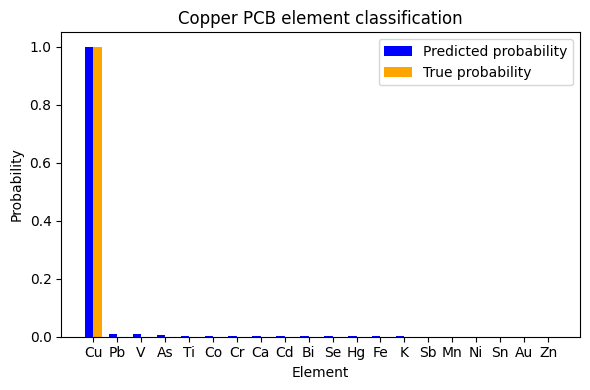

In [ ]:
n = 12
y_pred = model(torch.tensor(example_X[n].reshape(1, 1, 4096)).float().to(DEVICE))[0]

elements1, values1 = zip(*get_percentages_y(y_pred.tolist()))
elements2, values2 = zip(*get_percentages_y(example_y[n]))

bar_width = 0.35
index = np.arange(len(elements1))

fig, ax = plt.subplots(figsize=(6, 4))
rects1 = ax.bar(index, values1, bar_width, label='Predicted probability', color='blue')
rects2 = ax.bar(index + bar_width, values2, bar_width, label='True probability', color='orange')

ax.set_xlabel('Element')
ax.set_ylabel('Probability')
ax.set_title('Copper PCB element classification')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(elements1)
ax.legend()

plt.tight_layout()
plt.savefig("classification-results.svg")

